# SQL and Python: Alerts from time series predictions
- query data in Tinybird using SQL
- model time-series data using Prophet (python)
- write predictions to Tinybird
- compare the predictions to actual data
- alert in Tinybird when actual data is out of predicted limits using SQL
- plot actual against predicted

In [21]:
#@title Install the Tinybird CLI, libraries and your token
!pip install tinybird-cli -q -U

import os
import io
import pandas as pd

from fbprophet import Prophet
import matplotlib.pyplot as plt
from google.colab import files

!tb init
!tb auth

** - /datasources already exists, skipping
** - /datasources/fixtures already exists, skipping
** - /endpoints already exists, skipping
** - /explorations already exists, skipping
** - /pipes already exists, skipping
Copy the admin token from https://ui.tinybird.co/tokens and paste it here: 
** Auth successful! 
** Configuration written to .tinyb file, consider adding it to .gitignore


In [22]:
#@title Helper function
def write_text_to_file(filename, text):
  with open(filename, 'w') as f: f.write(text)

In [23]:
#@title Query data in Tinybird using SQL and create a pandas DataFrame
output=!tb sql --rows_limit 1000 --format csv \
"SELECT toDate(tpep_pickup_datetime) as date, \
count() as events FROM taxi GROUP BY date"

In [24]:
df=pd.read_csv(io.StringIO(output.n))
df=df[(df.date > '2018-00-00') & (df.date < '2020-00-00')]
print(len(df), 'rows in DataFrame')

730 rows in DataFrame


In [25]:
df.head()

,date,events
18,2018-01-01,237119
19,2018-01-02,238152
20,2018-01-03,266992
21,2018-01-04,122222
22,2018-01-05,265212


In [26]:
df.tail()

,date,events
743,2019-12-27,168061
744,2019-12-28,171034
745,2019-12-29,163808
746,2019-12-30,172965
747,2019-12-31,167615


In [27]:
#@title Model time-series data using Prophet (python) and generate predictions
days_to_predict = 31

prediction_df = pd.DataFrame()
prediction_df['ds'] = df.date
prediction_df['y'] = df.events

model = Prophet(daily_seasonality=True, 
                weekly_seasonality=True, 
                yearly_seasonality=True)
model.fit(prediction_df)

future = model.make_future_dataframe(periods=days_to_predict)
forecast = model.predict(future)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

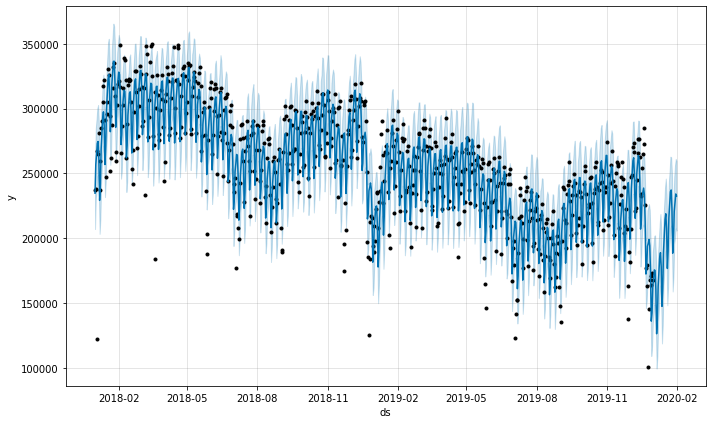

In [28]:
#@title Plot the historic data and the predictions for the next month
fig = model.plot(forecast)
fig.savefig('prophet_plot_1.jpg')
files.download('prophet_plot_1.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

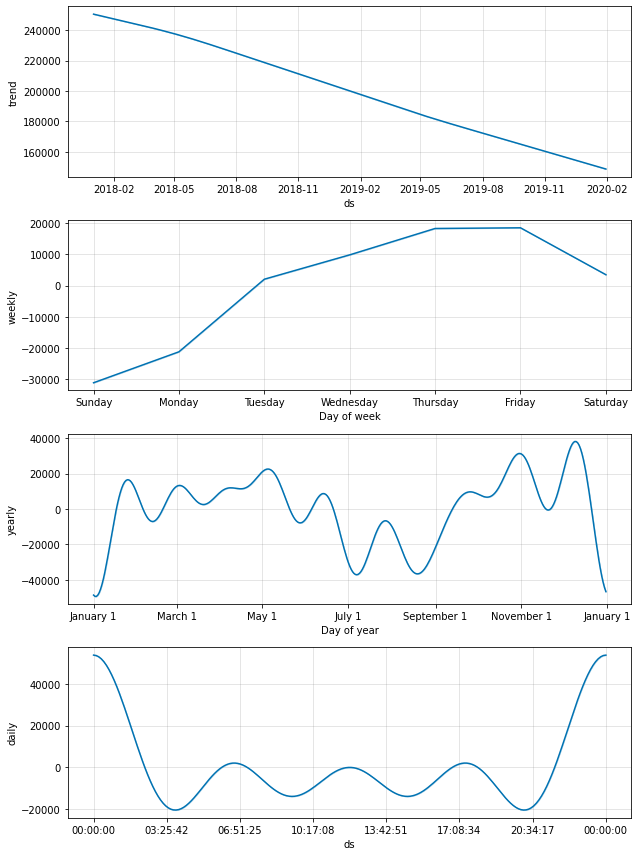

In [29]:
#@title Plot the components of the model
fig = model.plot_components(forecast)
fig.savefig('prophet_plot_2.jpg')
files.download('prophet_plot_2.jpg')

In [31]:
#@title Write the predictions to a Tinybird Data Source

for col in ['yhat_lower','yhat','yhat_upper']:
  forecast[col] = forecast[col].astype('int64')

forecast[['ds', 'yhat_lower', 'yhat', 'yhat_upper']].to_csv('./datasources/fixtures/forecast.csv', index=False)
!tb datasource generate ./datasources/fixtures/forecast.csv --force

** Generated datasources/forecast.datasource
** => Create it on the server running: $ tb push datasources/forecast.datasource
** => Append data using: $ tb datasource append forecast ./datasources/fixtures/forecast.csv`

** => Generated fixture datasources/fixtures/forecast.csv


In [32]:
!cat datasources/forecast.datasource

DESCRIPTION generated from ./datasources/fixtures/forecast.csv

SCHEMA >
    `ds` Date,
    `yhat_lower` Int64,
    `yhat` Int64,
    `yhat_upper` Int64

In [33]:
!tb datasource rm forecast --yes

** Data Source 'forecast' deleted


In [34]:
!tb push datasources/forecast.datasource --fixtures  

** Processing datasources/forecast.datasource
** Building dependencies
** Running forecast 
** 'forecast' created
** Pushing fixtures
** Checking forecast.datasource (appending 23.8 kb)
**  OK (1 blocks)


In [35]:
#@title Compare the predictions to the actual data for January 2020 in Tinybird using a Pipe and an Endpoint.
filename="pipes/actual_vs_expected.pipe"
text='''
DESCRIPTION >
  comparison of actual vs expected 

NODE actual_events
DESCRIPTION >
    events per day in January 2020
SQL >

    SELECT toDate(tpep_pickup_datetime) as ds, count() as events 
    FROM taxi_2020_01 
    WHERE ds > toDate('2019-12-31') AND ds < toDate('2020-02-01')
    GROUP BY ds

NODE with_predicted_events
DESCRIPTION >
    join with predicted events for January 2020
SQL >

    SELECT * FROM actual_events
    LEFT JOIN forecast
    USING ds

NODE beyond_the_limits
DESCRIPTION >
    identify anomalous days
SQL >

    SELECT *,
    If(events < yhat_lower, 'error', 'OK') AS anomaly_lower,
    If(events > yhat_upper, 'error', 'OK') AS anomaly_higher
    FROM with_predicted_events
'''

write_text_to_file(filename, text)

In [36]:
!tb push 'pipes/actual_vs_expected.pipe' --force --no-check

** Processing pipes/actual_vs_expected.pipe
** Warning: taxi_2020_01 not found inside: 
   - /content
   - /content/datasources
   - /content/endpoints
** Building dependencies
** Running actual_vs_expected 
** => Test endpoint at https://api.tinybird.co/v0/pipes/actual_vs_expected.json
** 'actual_vs_expected' created
** Not pushing fixtures


In [37]:
#@title The same results from clicking on the test Endpoint can be created in a pandas DataFrame.
output = !tb sql --format csv "SELECT toDate(tpep_pickup_datetime) as date, count() as events \
FROM taxi_2020_01 GROUP BY date"

forecast = forecast.set_index('ds')
df_actual = pd.read_csv(io.StringIO(output.n)).set_index('date')
df_actual = df_actual[(df_actual.index > '2020-01-00') & (df_actual.index < '2020-02-00')]
df_actual.index = pd.to_datetime(df_actual.index)
df_actual = df_actual.join(forecast[['yhat_lower', 'yhat', 'yhat_upper']])
df_actual['anomaly_lower'] = 'OK'
df_actual['anomaly_higher'] = 'OK'
df_actual.loc[df_actual.events < df_actual.yhat_lower, 'anomaly_lower'] = 'error'
df_actual.loc[df_actual.events > df_actual.yhat_upper, 'anomaly_higher'] = 'error'
df_actual

,events,yhat_lower,yhat,yhat_upper,anomaly_lower,anomaly_higher
date,,,,,,
2020-01-01,168578,140941,168549,195702,OK,OK
2020-01-02,160291,148958,175573,201913,OK,OK
2020-01-03,181520,148188,175105,202226,OK,OK
2020-01-04,181706,132897,160139,186934,OK,OK
2020-01-05,163038,99469,126310,152630,OK,error
2020-01-06,175535,109045,137655,165529,OK,error
2020-01-07,196964,135428,162965,188930,OK,error
2020-01-08,212584,145690,173420,200233,OK,error
2020-01-09,227500,156587,185033,211163,OK,error


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

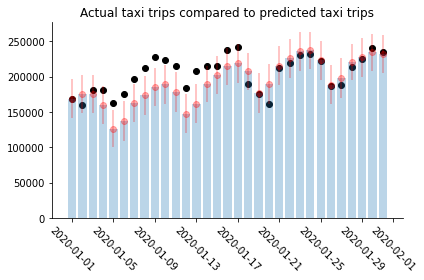

In [38]:
#@title Plot the predicted values with error bars and compare to the actual values
ax = plt.subplot(111)
plt.bar(df_actual.index, df_actual.yhat, alpha=.3)
plt.errorbar(df_actual.index, df_actual.yhat, 
             yerr=(df_actual.yhat_upper-df_actual.yhat_lower)/2, 
             fmt="o", color="r", alpha=.3)
plt.scatter(df_actual.index,df_actual.events, color="k")
plt.xticks(rotation=-45)
plt.title('Actual taxi trips compared to predicted taxi trips')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('actual_preds.jpg')
files.download('actual_preds.jpg');

In [39]:
#@title Alert: lower number of trips than expected
df_actual[df_actual.events < df_actual.yhat_lower]

,events,yhat_lower,yhat,yhat_upper,anomaly_lower,anomaly_higher
date,,,,,,
2020-01-20,161069,162817,189735,219430,error,OK


In [40]:
#@title Alert: higher number of trips than expected
df_actual[df_actual.events > df_actual.yhat_upper]

,events,yhat_lower,yhat,yhat_upper,anomaly_lower,anomaly_higher
date,,,,,,
2020-01-05,163038,99469,126310,152630,OK,error
2020-01-06,175535,109045,137655,165529,OK,error
2020-01-07,196964,135428,162965,188930,OK,error
2020-01-08,212584,145690,173420,200233,OK,error
2020-01-09,227500,156587,185033,211163,OK,error
2020-01-10,224085,163544,188860,218657,OK,error
2020-01-11,215631,150438,177812,206480,OK,error
2020-01-12,184056,118819,147452,174019,OK,error
2020-01-13,207317,132820,161754,188858,OK,error
